# Projet Maths-Info

## Id-Benaddi Anisse & Leconte Simon

## Construction de lignes de niveaux pour une fonction à deux paramètres

On prend f une fonction définie dans le carré unité $[0,1]^2$ et on limite dans un premier temps notre recherche aux lignes de niveau qui possèdent un point sur l'arête gauche du domaine de définition.

### Amorce

À quelle condition raisonnable portant sur $f(0,0)$ et $f(0,1)$ et le réel $c$ est-on certain qu'il existe $t \in [0,1]$ tel que $f(0,t)=c$ ?

Pour des fonctions continues, $f(0,0) \leq c \leq f(0,1)$ ou $f(0,1) \leq c \leq f(0,0)$ est une hypothèse suffisante - d'après le théorème des valeurs intermédiaires - , bien que non nécessaire. Elle peut sembler à priori contraignante, mais la division de la zone d'étude en de suffisamment petites zones nous permet d'avoir cette condition vérifiée, sous réserve de comportements non extrêmes.

#### Implémentation d'une fonction renvoyant un flottant éloigné d'au plus eps d'un tel t ou None si la condition évoquée ci-dessus n'est pas satisfaite

In [1]:
import autograd
from autograd import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def find_seed(g,c=0.0,eps=2**(-26)):
    a=0.0
    b=1.0
    if not(g(0,b)<c<g(0,a) or g(0,a)<c<g(0,b)):
        return None
    while abs(a-b)>eps:
        milieu = (a+b)/2
        if (g(0.0,milieu)<c) ^ (g(0,b)<g(0,a)):
            a=milieu
        else:
            b=milieu
    t=a
    return t

In [3]:
#Test
def g(x,y):
    return y
find_seed(g,0.31415926)

0.31415925920009613

### Propagation

Nous savons désormais trouver un point de départ pour notre tracé, il s'agit maintenant de prolonger ce tracé jusqu'à la sortie de l'espace délimité.

Nous utiliserons une méthode à base de gradient. Nous prolongerons le tracé en ligne droite dans la direction normale au gradient, opposée au début du tracé. Nous partirons nécessairement vers les $x$ croissants à la première étape, puis nous utiliserons un vecteur reliant le point à peine trouvé au point précédent. Le signe du produit vectoriel nous indique la direction à suivre.

In [4]:
def delta_normalisation(l,delta):
    """ Cette fonction prend en paramètre un gradient, et modifie sa norme de
    telle sorte qu'elle vaille delta en sortie """
    norme = np.sqrt(l[0]**2+l[1]**2)
    return l*delta/norme
def grad(f,x,y):
    """Cette fonction renvoit le gradient de f en (x,y)"""
    g=autograd.grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]
def simple_contour(f,c=0.0,delta = 0.01,eps = 2**(-26)):
    """ Entrée :
    Une fonction à deux paramètres réels à valeurs réelles : f
    Une valeur de ligne de niveau : c
    Un pas de propagation : delta
    Une précision pour la valeur initiale : eps

    Sortie :
    Deux listes de coordonnées des abscisses et des ordonnées de la ligne de
    niveau égale à c"""
    #Initialisation du tracé avec find_seed
    x0 = 0.0
    y0 = find_seed(f,c,eps)
    if y0==None:
        return [],[]
    tabX = [x0]
    tabY = [y0]
    #Première étape, nécessairement vers les x croissants
    #Calcul du gradient
    gradient = grad(f,x0,y0)
    grad_utile = delta_normalisation(gradient,delta)
    # Il faut distinguer le cas grad_utile[1]>0 et le cas grad_utile[1]<0 pour
    # savoir quelle normale au gradient choisir
    b = grad_utile[1]
    a = grad_utile[0]
    if b>0:
        tabX.append(x0+b)
        tabY.append(y0-a)
    else:
        tabX.append(x0-b)
        tabY.append(y0+a)
    #La première étape est terminée
    #Tant que l'on est encore dans la case [0,1]², on continue à prolonger
    while 0<=tabX[-1]<=1 and 0<=tabY[-1]<=1:
        #On commence par calculer le gradient normalisé au dernier point
        gradient = grad(f,tabX[-1],tabY[-1])
        grad_utile = delta_normalisation(gradient,delta)
        b = grad_utile[1]
        a = grad_utile[0]
        deplacementPrecedent = (tabX[-2]-tabX[-1],tabY[-2]-tabY[-1])
        #On calcule le produit vectoriel entre le déplacement précédent et le
        #gradient actuel pour déterminer la direction de déplacement à l'étape
        #suivante
        vectoriel = deplacementPrecedent[0]*b-deplacementPrecedent[1]*a
        #Selon le signe du produit vectoriel, on détermine quelle normale au
        #gradient choisir
        if vectoriel > 0:
            tabX.append(tabX[-1]-b)
            tabY.append(tabY[-1]+a)
        else:
            tabX.append(tabX[-1]+b)
            tabY.append(tabY[-1]-a)
    return tabX,tabY

Testons cet algorithme à l'aide de différentes fonctions

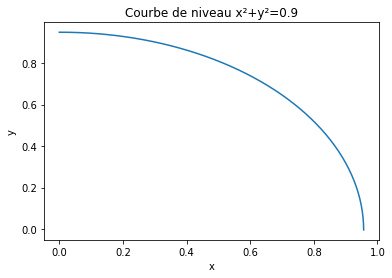

In [5]:
def f(x,y):
    return x**2+y**2
x,y=simple_contour(f,c=0.9)
plt.clf()
plt.plot(x,y)
plt.title("Courbe de niveau x²+y²=0.9")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

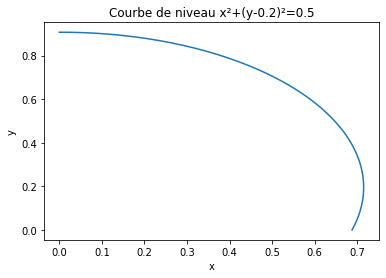

In [6]:
def f(x,y):
    return x**2+(y-0.2)**2
x,y=simple_contour(f,c=0.5)
plt.clf()
plt.plot(x,y)
plt.title("Courbe de niveau x²+(y-0.2)²=0.5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

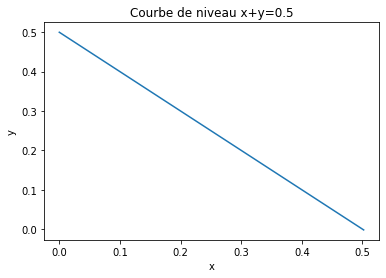

In [7]:
def f(x,y):
    return x+y
x,y=simple_contour(f,c=0.5)
plt.clf()
plt.plot(x,y)
plt.title("Courbe de niveau x+y=0.5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Le principal défaut de cette fonction est qu'elle accumule les erreurs, étape après étape. Il faudra donc veiller dans la partie suivante à utiliser de nouveau la méthode de dichotomie de find_seed à chaque nouvelle case. Nous n'accumulerons de cette façon pas l'erreur sur tout le tracé du graphe, mais seulement sur une petite case, que l'on pourra rendre aussi petite que nécessaire. 

### Contour complexe

Afin de limiter les erreurs liée à l'accumulation, et pour gérer la multiplicité des solutions, il est nécessaire de diviser l'espace en « cases » plus petites, dans lesquelles $f(x,y)=c \Leftrightarrow \psi_c(x)=y$

Avec la fonction contour donnée sur la discussion discourse :

In [8]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

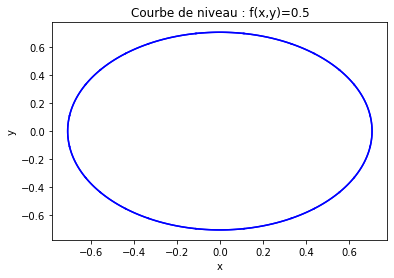

In [9]:
def f(x,y):
    return x**2+y**2
resultat=contour(f,0.5,xs=np.linspace(-1,1,10),ys=np.linspace(-1,1,10))
plt.clf()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Courbe de niveau : f(x,y)=0.5")
for (x,y) in resultat:
    plt.plot(x,y,color="blue")

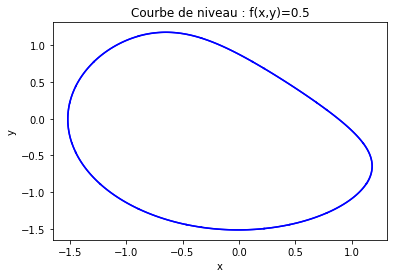

In [10]:
def f(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))
resultat=contour(f,0.2,xs=np.linspace(-2,3,10),ys=np.linspace(-2,3,10))
plt.clf()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Courbe de niveau : f(x,y)=0.5")
for (x,y) in resultat:
    plt.plot(x,y,color="blue")

On obtient bien le résultat attendu. Remarquons que pour éviter d'avoir des accumulations d'erreur trop importante, nous avons divisé l'espace en 100 sous-cases. 